In [1]:
import osmnx as ox
from itertools import combinations
import networkx as nx

radius = 5000
center = ox.geocoder.geocode("UCSD")
layers = ["drive", "bike", "walk"]
multi_network = {}
for l in layers:
    multi_network[l] = ox.graph.graph_from_point(center, radius, network_type=l)

In [2]:
# fig, ax = ox.plot.plot_graph(drive_network, node_color=nc)
for l in multi_network:
    multi_network[l] = ox.routing.add_edge_speeds(multi_network[l])
    multi_network[l] = ox.routing.add_edge_travel_times(multi_network[l])

In [3]:
# multi_network["walk"].nodes

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def visualize_partitions(G, partitions, title="communities"):
    # so our partitions are a list of sets of nodes.
    
    # enumerate each partition with an "id".
    # assign each node to a community tag
    node_community = {}
    for community_id, community in enumerate(partitions):
        for node in community:
            node_community[node] = community_id
    
    # Get community ids for each node in the graph, ordered same way as in G.
    # we map each community id to a color (then we can give each node a color, ordered
    # in the same way as G.)
    # community_ids = [node_community[node] for node in G.nodes()]
    
    # Generate colors for each community
    # use rainbow instead of viirdis bc too many colours.
    # unsure how to map colours in a way such that close colours aren't together.
    colors = cm.rainbow(np.linspace(0, 1, len(partitions)))
    node_colors = [colors[node_community[node]] for node in G.nodes()]


    # print(node_colors)
    # Plot the graph
    fig, ax = ox.plot_graph(
        G, 
        node_color=node_colors,
        node_size=20,
        edge_linewidth=1,
        show=False,
        close=False
    )
    ax.set_title(title)

    print(
plt.gca().get_xlim(), plt.gca().get_ylim() )
    plt.show()

(-117.283798122, -117.174113378) (32.832500411999995, 32.926006188)


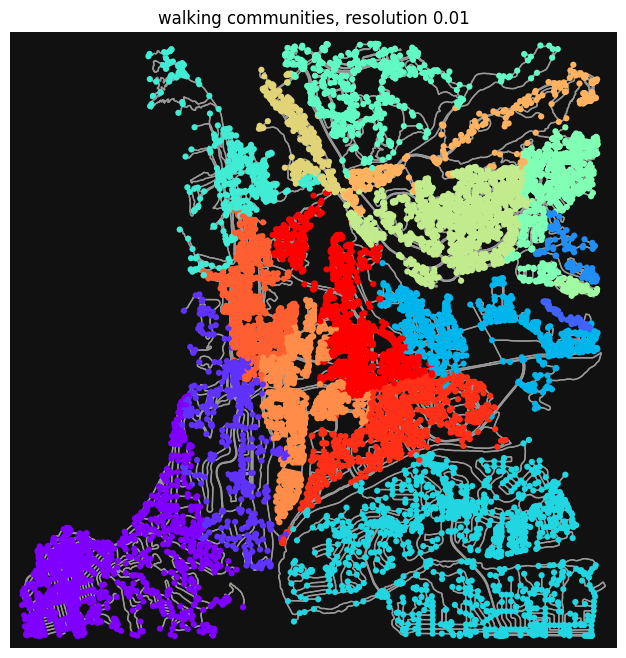

(-117.283798122, -117.174113378) (32.832500411999995, 32.926006188)


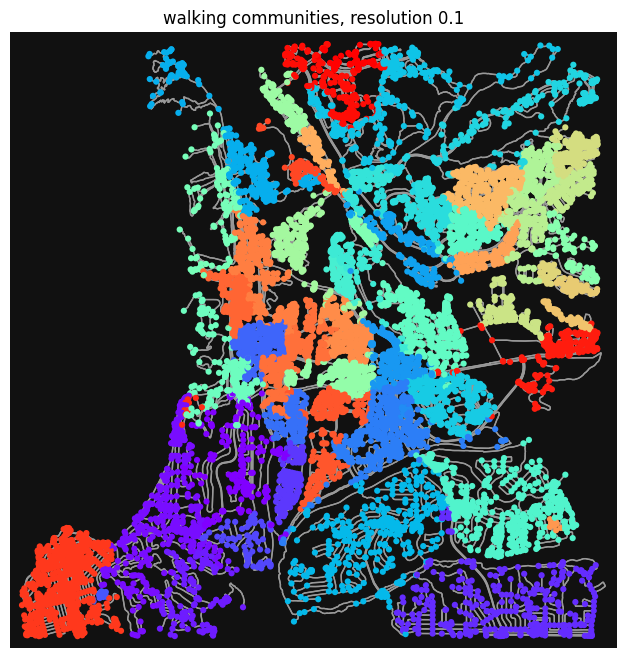

(-117.283798122, -117.174113378) (32.832500411999995, 32.926006188)


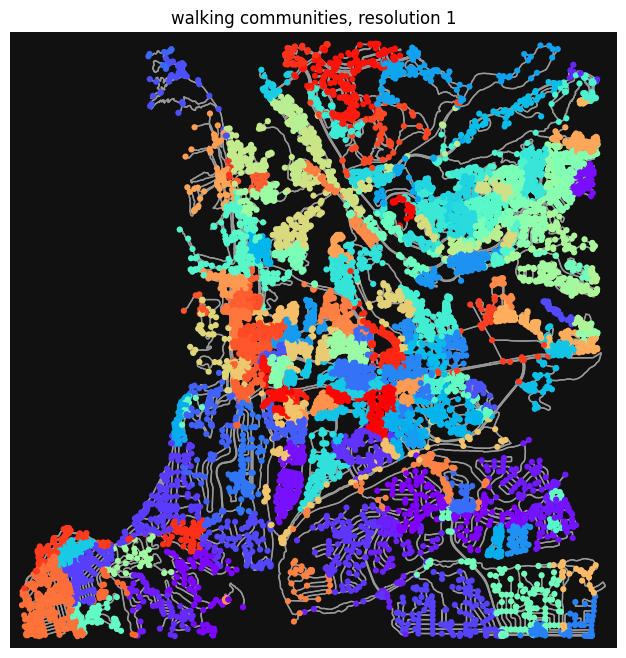

In [5]:
# let's check out walking partitions.

partitions_walk_resolution = {}
resolutions = [0.01, 0.1, 1]
for res in resolutions:
    partitions_walk_resolution[res] = nx.algorithms.community.louvain_communities(multi_network["walk"], weight="travel_time", resolution=res)

    visualize_partitions(
        multi_network["walk"], 
        partitions_walk_resolution[res], 
        title=f"walking communities, resolution {res}"
    )

In [6]:
def getDistanceInfoLouvain(G, p):
    distances = []
    for partition in p:
        distances.append(nx.diameter(G.subgraph(partition), weight="travel_time"))

    return distances

In [7]:
dists = {}
for res in resolutions:
    dists[res] = getDistanceInfoLouvain(multi_network["walk"], partitions_walk_resolution[res])
# this takes ages. do we ereally need to do it?

In [8]:
# quantitative info on how resolution affects community size. 
for res in dists:
    print(f"distances {res}: mean {np.mean(dists[res])} max {np.max(dists[res])} min {np.min(dists[res])}")
    node_lens = [len(r) for r in partitions_walk_resolution[res]]
    print(f"nodes {res}: mean {np.mean(node_lens)} max {np.max(node_lens)} min {np.min(node_lens)}")
# can we draw some type of conclusion from this?

distances 0.01: mean 523.1869427594337 max 867.9948418153607 min 108.46357316074815
nodes 0.01: mean 923.1176470588235 max 1760 min 56
distances 0.1: mean 321.75481933803485 max 785.0891863170286 min 44.05620668325063
nodes 0.1: mean 285.3272727272727 max 922 min 12
distances 1: mean 187.9448692896962 max 714.8062324195538 min 12.793560319890446
nodes 1: mean 83.47340425531915 max 294 min 9


In [9]:
ud_graphs = {G: ox.convert.to_undirected(multi_network[G]) for G in multi_network}
# explain that compose will use attributes of the second graph if they are duplicated IDs:
# this means that we are prioritising walking in this graph.
combine = nx.compose(ud_graphs["drive"], ud_graphs["walk"])
combine_lv = nx.algorithms.community.louvain_communities(combine, weight="travel_time", resolution=0.1)

In [10]:
combine_dists = getDistanceInfoLouvain(combine, combine_lv)

(-117.283798122, -117.174113378) (32.832500411999995, 32.926006188)


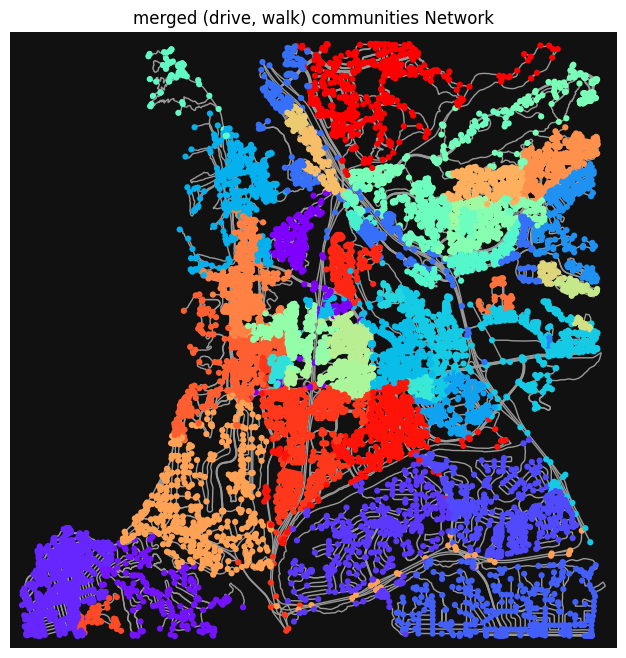

In [11]:
visualize_partitions(
    combine, 
    combine_lv, 
    title=f"merged (drive, walk) communities Network"
)

# print(f"distances : mean {np.mean(combine_dists)} max {np.max(combine_dists)} min {np.min(combine_dists)}")
# node_lens = [len(r) for r in partitions_walk_resolution[res]]
# print(f"nodes : mean {np.mean(node_lens)} max {np.max(node_lens)} min {np.min(node_lens)}")

In [12]:
# explain what we can learn from this.

(-117.28361187, -117.17411702999999) (32.832506532000004, 32.925969668)


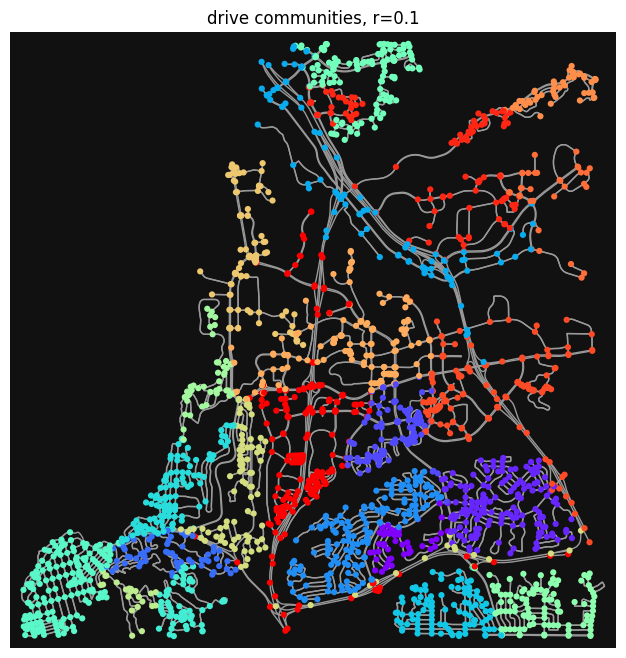

(-117.28361187, -117.17411702999999) (32.832501126, 32.925969774)


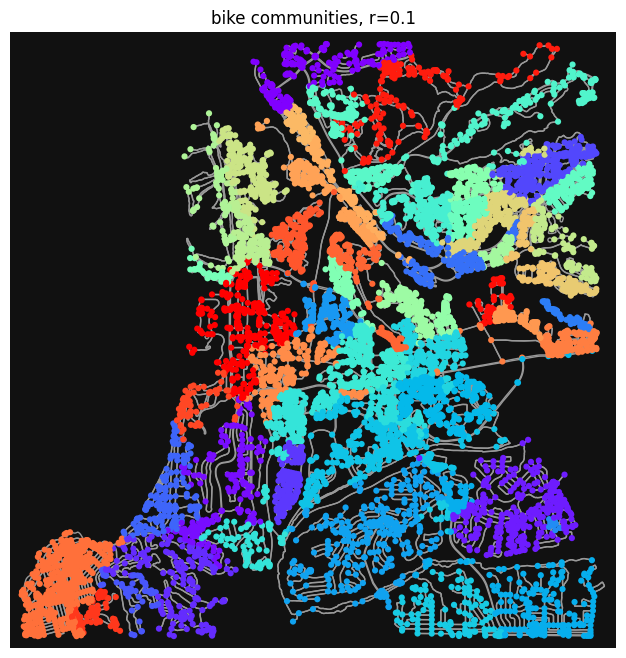

(-117.283798122, -117.174113378) (32.832500411999995, 32.926006188)


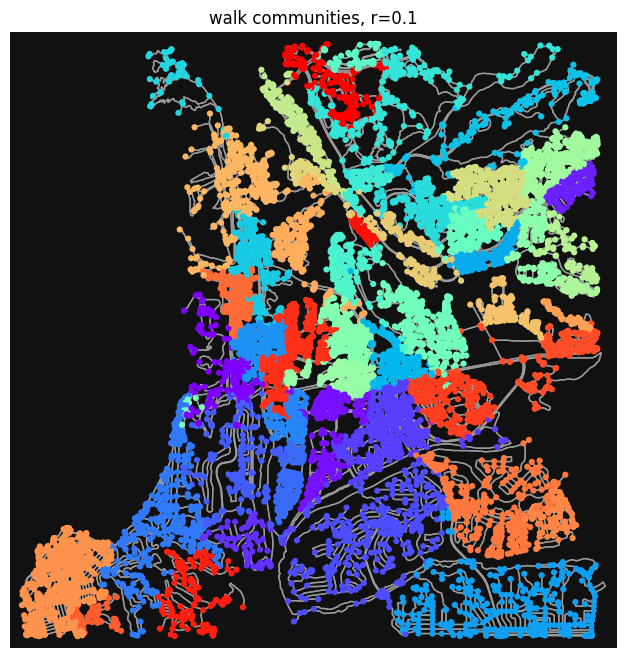

In [16]:
partitions_all = {}
dists_all = {}

for mode in multi_network:
    partitions_all[mode] = nx.algorithms.community.louvain_communities(multi_network[mode], 
                      weight="travel_time", resolution=0.1)

    visualize_partitions(
        multi_network[mode], 
        partitions_all[mode], 
        title=f"{mode} communities, r=0.1"
    )

    # dists_all[mode] = getDistanceInfoLouvain(multi_network[mode], partitions_all[mode])